<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_04_02_survival_analysis_prentice_williams_peterson_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 4.2 Prentice-Williams-Peterson (PWP) Models {.unnumbered}


In many longitudinal studies, subjects may experience **multiple occurrences of the same event**—such as hospital readmissions, seizures, or equipment failures. While the **Andersen-Gill (AG) model** treats all events as independent increments in a counting process, it ignores the **natural ordering and history** of events (e.g., time since last event or number of prior events).

This tutorial explains the PWP framework, demonstrates how to implement both PWP-GT and PWP-TT models in R, covers data preparation, model fitting, diagnostics, and visualization of the **Mean Cumulative Function (MCF)**—the recurrent-event analog of the Cumulative Incidence Function (CIF).


## Overview


Prentice-Williams-Peterson (PWP) models are extensions of the Cox proportional hazards model specifically designed for analyzing recurrent event data, where the same type of event (e.g., infections, hospitalizations, or tumor recurrences) can occur multiple times for an individual. Unlike standard survival analysis for single events, PWP models account for the ordering and dependency of repeated events by stratifying the analysis based on the number of prior events. This stratification creates conditional risk sets: all subjects are at risk for the first event, but only those who experienced the first are at risk for the second, and so on.

PWP models are particularly useful in epidemiology and clinical studies, such as tracking recurrent infections in patients with chronic conditions (e.g., cystic fibrosis or kidney disease) or repeated sports injuries. They allow for event-specific covariate effects, meaning the impact of predictors like treatment or age can vary across event orders. However, if the number of events is large, risk sets for later events may become small, leading to unstable estimates—often requiring truncation (e.g., analyzing only the first 3-4 events).



There are two main variants:

-   **PWP-TT (Total Time or Conditional Risk Set Model)**: Measures time from study entry to each event, similar to calendar time. It's suitable when the overall timeline matters, and it assumes a common baseline hazard within each stratum (event order) but allows covariate effects to differ.

-   **PWP-GT (Gap Time Model)**: Measures the time between consecutive events (inter-event gaps), resetting the clock after each event. This assumes a renewal process and is ideal for focusing on waiting times between recurrences, such as predicting the time to the next event.

| Model | Time Scale | Interpretation |
|----|----|----|
| **PWP-GT (Gap Time)** | Time since *previous* event | "What is the risk of the *k*-th event given the (*k–1*)-th occurred?" |
| **PWP-TT (Total Time)** | Time since *study entry* | "What is the risk of the *k*-th event at calendar time *t*?" |

The PWP model **stratifies by event number** (1st event, 2nd event, etc.), allowing the baseline hazard to differ across event orders. This acknowledges that the risk of a second event may differ from the first due to biological, behavioral, or mechanical factors.


### Key Assumptions


-   Subjects are **not at risk for the *k*-th event until the (*k–1*)-th event has occurred**.
-   The baseline hazard is **unspecified and unique for each event order** (handled via stratification).
-   Covariate effects (β) are often assumed **constant across event orders** (can be relaxed).


### When to Use PWP


-   Event history matters (e.g., risk changes after first recurrence)\
-   Interest in **time between events** (PWP-GT) or **calendar-time risk of ordered events** (PWP-TT)\
-   Events are **ordered and of the same type**

> **Not suitable** if subjects can experience events without prior ones (e.g., simultaneous events).


### Strengths


-   Accounts for **event order** via stratification.
-   Flexible: allows different baseline hazards per event.
-   Can incorporate time-varying covariates.


### Limitations


-   **Does not model correlation** between gap times beyond stratification (frailty models may be better).
-   **Excludes subjects** from risk sets for higher-order events until prior events occur (reduces power).
-   Interpretation is **conditional on having reached that event order**.


### PWP vs. AG Model


| Feature | AG Model | PWP Model |
|----|----|----|
| **Time scale** | Calendar time | TT: calendar; GT: gap time |
| **Event dependence** | Assumes independence (robust SEs) | Explicitly models order via strata |
| **At-risk assumption** | Always at risk until censoring | Only at risk for *k*-th event after (*k–1*)-th occurs |
| **Best for** | Event *rate* over time | Event *timing/order* |


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316565 sha256=fe0d452f5a80b0cd663c878a49775718b1c8e7395a17bc0dbc1cbb60c44ced13
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Implementation in R


We’ll use simulated recurrent event data and fit both PWP-GT and PWP-TT models using the `survival` package.


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [3]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'riskRegression',
		 'reda'
		 )


### Install missing packages

In [ ]:
%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')

In [4]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk riskRegression           reda 
          TRUE           TRUE           TRUE           TRUE           TRUE 


### Load Packages

In [5]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [6]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:reda"           "package:riskRegression" "package:cmprsk"        
 [4] "package:timereg"        "package:ggfortify"      "package:tidycmprsk"    
 [7] "package:ggsurvfit"      "package:survminer"      "package:ggpubr"        
[10] "package:survival"       "package:lubridate"      "package:forcats"       
[13] "package:stringr"        "package:dplyr"          "package:purrr"         
[16] "package:readr"          "package:tidyr"          "package:tibble"        
[19] "package:ggplot2"        "package:tidyverse"      "package:tools"         
[22] "package:stats"          "package:graphics"       "package:grDevices"     
[25] "package:utils"          "package:datasets"       "package:methods"       
[28] "package:base"          


### Data


We use the `surviva`l package and `bladder1` dataset, which contains recurrent bladder tumor data. The data set contains multiple rows per patient, with start and stop times for each interval, event indicators, and covariates.

`id`:	Patient id
`treatment`:	Placebo, pyridoxine (vitamin B6), or thiotepa
`number`:	Initial number of tumours (8=8 or more)
`size`:	Size (cm) of largest initial tumour
`recur`:	Number of recurrences
`start,stop`:	The start and end time of each time interval
`status`:	End of interval code, 0=censored, 1=recurrence, 2=death from bladder disease, 3=death other/unknown cause
`rtumor`:	Number of tumors found at the time of a recurrence
`rsize`:	Size of largest tumor at a recurrence
`enum`:	Event number (observation number within patient)


In [7]:
%%R
# Load bladder1 (long format)
data(bladder1)
str(bladder1)

'data.frame':	294 obs. of  11 variables:
 $ id       : int  1 2 3 4 5 6 6 7 8 9 ...
 $ treatment: Factor w/ 3 levels "placebo","pyridoxine",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ number   : int  1 1 2 1 5 4 4 1 1 1 ...
 $ size     : int  1 3 1 1 1 1 1 1 1 3 ...
 $ recur    : int  0 0 0 0 0 1 1 0 0 1 ...
 $ start    : int  0 0 0 0 0 0 6 0 0 0 ...
 $ stop     : int  0 1 4 7 10 6 10 14 18 5 ...
 $ status   : num  3 3 0 0 3 1 3 0 0 1 ...
 $ rtumor   : chr  "." "." "." "." ...
 $ rsize    : chr  "." "." "." "." ...
 $ enum     : num  1 1 1 1 1 1 2 1 1 1 ...


### Data Preparation


We will create gaptime for PWP-GT and truncate to the first 4 events for stable risk sets:


In [8]:
%%R
# Identify problematic rows
invalid_intervals <- bladder1[bladder1$stop <= bladder1$start, ]
invalid_status <- bladder1[!bladder1$status %in% c(0, 1), ]

# Remove invalid rows
bladder1_clean <- bladder1 %>%
  filter(stop > start, status %in% c(0, 1))

# Create gaptime for PWP-GT
bladder1_clean <- bladder1_clean %>%
  group_by(id) %>%
  mutate(gaptime = stop - start) %>%
  ungroup()

# Truncate to first 4 events for PWP models
bladder_trunc <- bladder1_clean[bladder1_clean$enum <= 4, ]

# Verify
head(bladder_trunc)

# A tibble: 6 × 12
     id treatment number  size recur start  stop status rtumor rsize  enum
  <int> <fct>      <int> <int> <int> <int> <int>  <dbl> <chr>  <chr> <dbl>
1     3 placebo        2     1     0     0     4      0 .      .         1
2     4 placebo        1     1     0     0     7      0 .      .         1
3     6 placebo        4     1     1     0     6      1 1      1         1
4     7 placebo        1     1     0     0    14      0 .      .         1
5     8 placebo        1     1     0     0    18      0 .      .         1
6     9 placebo        1     3     1     0     5      1 2      4         1
# ℹ 1 more variable: gaptime <int>


### Model Fitting

#### PWP-TT (otal Time, stratified by event order) Model

In [13]:
%%R
pwp_tt_fit <- coxph(Surv(start, stop, status) ~ treatment + number + size + strata(enum) + cluster(id),
                    data = bladder_trunc, robust = TRUE)
summary(pwp_tt_fit)

Call:
coxph(formula = Surv(start, stop, status) ~ treatment + number + 
    size + strata(enum), data = bladder_trunc, robust = TRUE, 
    cluster = id)

  n= 216, number of events= 149 

                        coef exp(coef) se(coef) robust se      z Pr(>|z|)  
treatmentpyridoxine  0.01842   1.01859  0.21156   0.25150  0.073   0.9416  
treatmentthiotepa   -0.21361   0.80766  0.21185   0.18601 -1.148   0.2508  
number               0.10925   1.11544  0.04400   0.04574  2.388   0.0169 *
size                 0.01889   1.01907  0.05110   0.05280  0.358   0.7206  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
treatmentpyridoxine    1.0186     0.9818    0.6222     1.668
treatmentthiotepa      0.8077     1.2381    0.5609     1.163
number                 1.1154     0.8965    1.0198     1.220
size                   1.0191     0.9813    0.9189     1.130

Concordance= 0.615  (se = 0.029 )
Likelihood ratio test= 6

#### PWP-GT (Gap Time, stratified by event order) Model

In [14]:
%%R
pwp_gt_fit <- coxph(Surv(gaptime, status) ~ treatment + number + size + strata(enum) + cluster(id),
                    data = bladder_trunc, robust = TRUE)
summary(pwp_gt_fit)

Call:
coxph(formula = Surv(gaptime, status) ~ treatment + number + 
    size + strata(enum), data = bladder_trunc, robust = TRUE, 
    cluster = id)

  n= 216, number of events= 149 

                         coef exp(coef)  se(coef) robust se      z Pr(>|z|)   
treatmentpyridoxine -0.003212  0.996793  0.206778  0.229990 -0.014  0.98886   
treatmentthiotepa   -0.204154  0.815337  0.205963  0.203142 -1.005  0.31491   
number               0.142757  1.153450  0.043835  0.045034  3.170  0.00152 **
size                 0.024727  1.025035  0.049948  0.052969  0.467  0.64063   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
treatmentpyridoxine    0.9968     1.0032    0.6351     1.564
treatmentthiotepa      0.8153     1.2265    0.5475     1.214
number                 1.1534     0.8670    1.0560     1.260
size                   1.0250     0.9756    0.9240     1.137

Concordance= 0.602  (se = 0.029 )
Likelihood ra


> **Note**: - `cluster(id)` provides robust standard errors. - `strata(event_order)` allows baseline hazard to vary by event number. - In PWP-GT, the **first event** is often analyzed separately (as it has no prior gap).



### Model Diagnostic

#### Proportional Hazards Check

          chisq df    p
treatment 0.355  2 0.84
number    0.880  1 0.35
size      1.053  1 0.30
GLOBAL    2.728  4 0.60


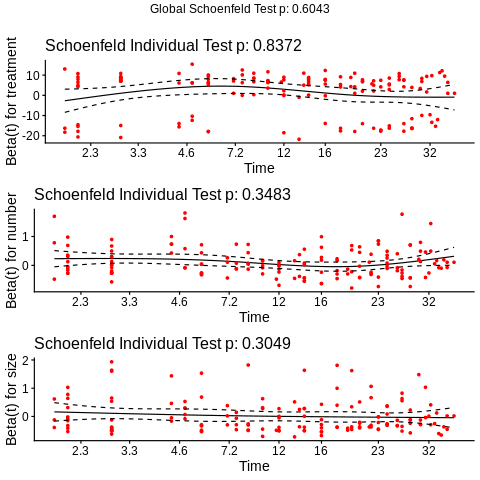

In [15]:
%%R
# For PWP-TT
zph_tt <- cox.zph(pwp_tt_fit)
print(zph_tt)
ggcoxzph(zph_tt)

           chisq df    p
treatment 2.8188  2 0.24
number    0.0116  1 0.91
size      0.2162  1 0.64
GLOBAL    3.2800  4 0.51


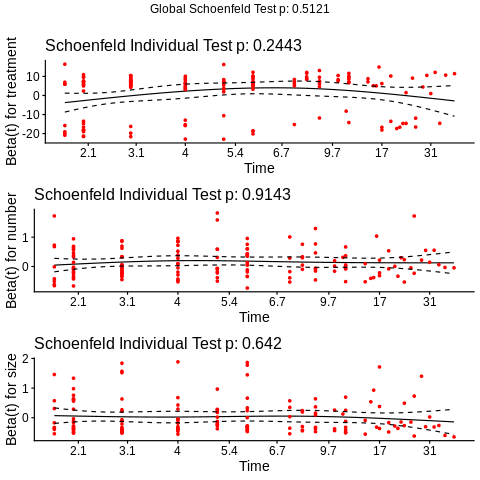

In [16]:
%%R
# For PWP-GT
zph_gt <- cox.zph(pwp_gt_fit)
print(zph_gt)
ggcoxzph(zph_gt)


> If PH violated for a stratum, consider time-dependent effects or separate models per event order.


#### Residuals


Martingale residuals can be examined per stratum:


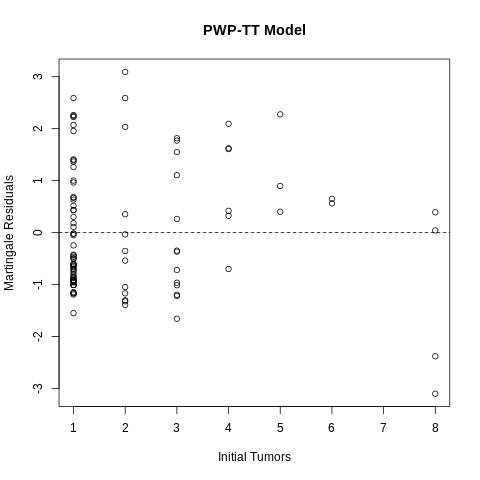

In [17]:
%%R
res_PWP_tt <- residuals(pwp_tt_fit, type = "martingale", collapse = bladder_trunc$id)
plot(res_PWP_tt ~bladder_trunc$number[match(names(res_PWP_tt), bladder_trunc$id)],
     xlab = "Initial Tumors",
     ylab = "Martingale Residuals",
     main = "PWP-TT Model")
abline(h = 0, lty = 2)

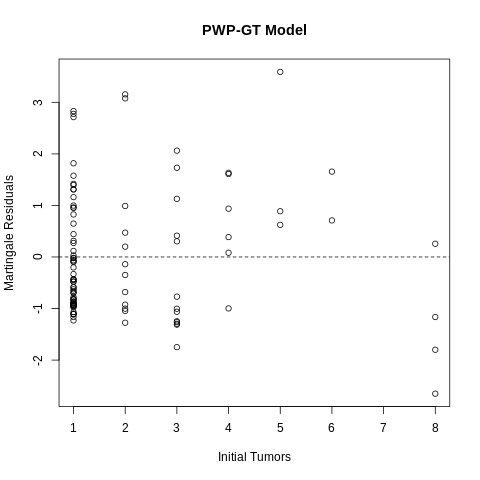

In [18]:
%%R
res_PWP_gt <- residuals(pwp_gt_fit, type = "martingale", collapse = bladder_trunc$id)
plot(res_PWP_gt ~bladder_trunc$number[match(names(res_PWP_gt), bladder_trunc$id)],
     xlab = "Initial Tumors",
     ylab = "Martingale Residuals",
     main = "PWP-GT Model")
abline(h = 0, lty = 2)

### Estimating and Plotting the Mean Cumulative Function (MCF)


While PWP models estimate **hazard ratios per event order**, the **Mean Cumulative Function (MCF)** shows the **average number of events per subject over time**—the recurrent-event analog of CIF.

We’ll use the `reda` package:


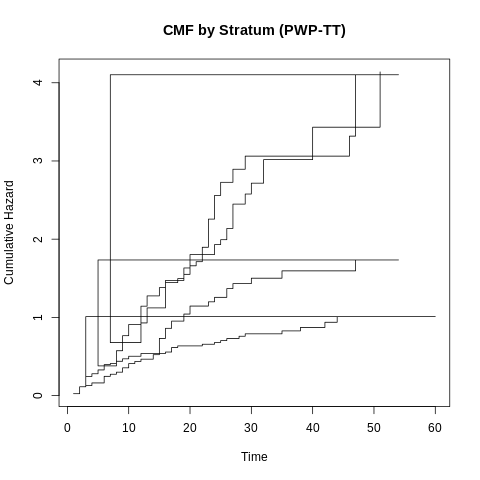

In [19]:
%%R
base_tt <- basehaz(pwp_tt_fit, centered = FALSE)
plot(base_tt$hazard ~ base_tt$time, type = "s", xlab = "Time", ylab = "Cumulative Hazard",
     main = "CMF by Stratum (PWP-TT)")

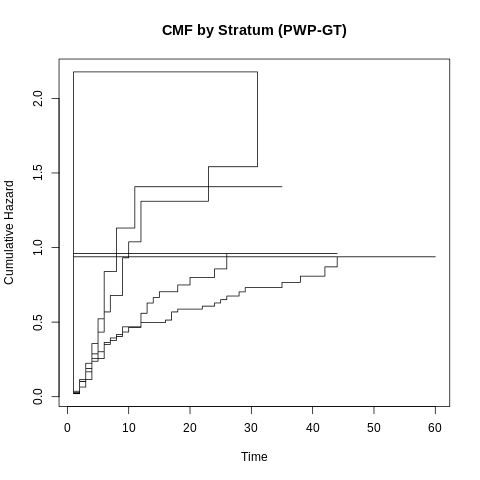

In [20]:
%%R
base_gt <- basehaz(pwp_gt_fit, centered = FALSE)
plot(base_gt$hazard ~ base_gt$time, type = "s", xlab = "Time", ylab = "Cumulative Hazard",
     main = "CMF by Stratum (PWP-GT)")




> **Note**: The MCF is **not directly output by PWP models**—it’s a descriptive summary of the event process, often used alongside modeling.


## Summary & Conclusions


This tutorial demonstrated how to implement Prentice-Williams-Peterson (PWP) models for recurrent event data in R, covering both PWP-TT and PWP-GT variants. Key steps included: data preparation, model fitting with `coxph()`, diagnostics, and visualization of the Mean Cumulative Function (MCF). This tutorial provides a foundational implementation. For full applications, consult the `survival` package vignettes or supplementary materials from epidemiological studies.


## Resources


**Books**

-   *The Statistical Analysis of Recurrent Events* by Cook & Lawless\
-   *Modeling Survival Data: Extending the Cox Model* by Therneau & Grambsch

**R Packages**

-   [`survival`](https://cran.r-project.org/package=survival): Core Cox models with `strata()`
-   [`reda`](https://cran.r-project.org/package=reda): MCF estimation and recurrent event simulation
-   [`frailtypack`](https://cran.r-project.org/package=frailtypack): Frailty models for recurrent events

**Vignettes & Tutorials**

-   `vignette("survival")` and `vignette("timedep", package = "survival")`
-   `vignette("reda-intro", package = "reda")`
-   Therneau’s [Advanced Survival Analysis Notes](https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf)